# Inicialização

In [1]:
!pip install darts -q
!pip3 uninstall statsmodels -y
!pip3 install numpy scipy patsy pandas
!pip3 install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build

Importações

In [2]:
import pickle
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
from darts import TimeSeries
from darts.dataprocessing.transformers.reconciliation import MinTReconciliator

Configurações de visualização de pandas Dataframe

In [3]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)

## Funções

In [4]:
def criar_hierarquia():
    hierarchy = dict()
    # Itens que não devem ser iterados (totais)

    # Para cada Item nas colunas:
    for i in df_final.columns:
        # Condicional
        if i != 'ano' and i != 'TOTAL':

            # Text_split = i (nome da coluna) separado por " - "
            text_split = i.split(' - ')
            # Lenf é igual ao tamanho do texto separado (nível hierarquico)
            lenf = len(text_split)
            # Nova lista que irá conter as suas hierarquias superiores
            new_list = [] 

            # Enquanto o contador (tamanho do texto separado) for maior que 1:
            while lenf > 1:
                # Debugger
                new_list.append(' - '.join(text_split[0:lenf-1]))
                lenf-= 1
            hierarchy[i] = new_list
            
    keys = []
    for k, v in hierarchy.items():
        if len(v) == 0:
            hierarchy[k] = ['TOTAL']

    return hierarchy

In [5]:
class Plot_base:


    def __init__(self, ts, predict, score):
        self.ts = ts
        self.predict = predict
        self.score = score

    def show(self, main_var, y_label, title, ignored_labels=[]):
        plt.figure(figsize=(14, 8))
        plt.ticklabel_format(style='plain')
        colors = ['r', 'g', 'b', 'maroon', 'darkcyan', 'peru', 'slategray']

        try:
            score_main_var = round(float(self.score[main_var]),2)
        except:
            score_main_var = self.score[main_var]
        
        self.ts[main_var].plot(lw=1, label = 'TOTAL', color = 'black')
        self.predict[main_var].plot(lw=2,label =f'COEF_VAR: {score_main_var}%', color = 'black', linestyle='--')

        for i,j in zip(dict_plot[main_var], colors):

            if i not in ignored_labels:
                try:
                    try:
                        score_i = round(self.score[i],2)
                    except(TypeError):
                        score_i = self.score[i]
                    i_label = i.split(' - ')[-1]
                    self.ts[i].plot(lw=1, label = f'{i_label}', color = j)
                    self.predict[i].plot(lw=2,label =f'COEF_VAR: {score_i}%', color = j, linestyle='--')
                
                except KeyError:
                    print(f'Variável {i} não encontrada... Ignorando varável')

        try:
            mean_concat = round((self.score[ignored_labels[0]]+self.score[ignored_labels[1]])/2,2)

            self.ts[ignored_labels].sum(axis=1).plot(lw=1, label = '*REGINTER_BREVES + REGINTER_BELEM', color = 'red')
            self.predict[ignored_labels].sum(axis=1).plot(lw=2,label =f'COEF_VAR ~ {mean_concat}%', color = 'red', linestyle='--')
        except:
            pass


        plt.title(title, fontweight="bold", fontsize=12)
        plt.xticks(list(range(1985,2027)), rotation=45)
        plt.grid(axis='x')
        plt.ylabel(y_label)
        plt.xlabel('Ano')
        plt.show()

## Carregamento de dados & reconciliação

In [6]:
with open('/content/drive/MyDrive/Dados/standarized/hierarchy/hierarchy_31-03-2023.pkl', 'rb') as fp:
    hierarchy = pickle.load(fp)
with open('/content/drive/MyDrive/Dados/standarized/dict_plot/dict_plot_31-03-2023.pkl', 'rb') as fp:
    dict_plot = pickle.load(fp)


df_final = pd.read_csv('/content/drive/MyDrive/Dados/standarized/time_series/time_series_02-04-2023.csv')
predict_arima = pd.read_csv('/content/drive/MyDrive/Dados/standarized/forecast_ts/03-04-2023.csv')

try:
    predict_arima = TimeSeries.from_dataframe(predict_arima, time_col= 'ano', hierarchy = hierarchy)
    ts_all = TimeSeries.from_dataframe(df =df_final, time_col= 'ano', value_cols=df_final.columns.drop('ano'), hierarchy=hierarchy)
except ValueError:
    hierarchy = criar_hierarquia()
    
    ts_all = TimeSeries.from_dataframe(df =df_final, time_col= 'ano', value_cols=df_final.columns.drop('ano'), hierarchy=hierarchy)
    predict_arima = TimeSeries.from_dataframe(predict_arima, time_col= 'ano', hierarchy = hierarchy)

score_arima = pd.read_csv('/content/drive/MyDrive/Dados/standarized/score/COEF/03-04-2023.csv').drop(columns = 'Unnamed: 0').to_dict(orient='records')[0]

for i in ts_all.components:
    if i not in predict_arima.columns:
        predict_arima[i] = 0
        score_arima[i] = '--'



reconciliator = MinTReconciliator(method="wls_val")
reconciliator.fit(ts_all)
predict_arima = reconciliator.transform(predict_arima)

ERROR:main_logger:ValueError: The keys of the hierarchy must be time series components


# Plots

## Instanciação de plots

In [7]:
plot_base = Plot_base(ts_all, predict_arima, score_arima)

## Rebanho

### Pará

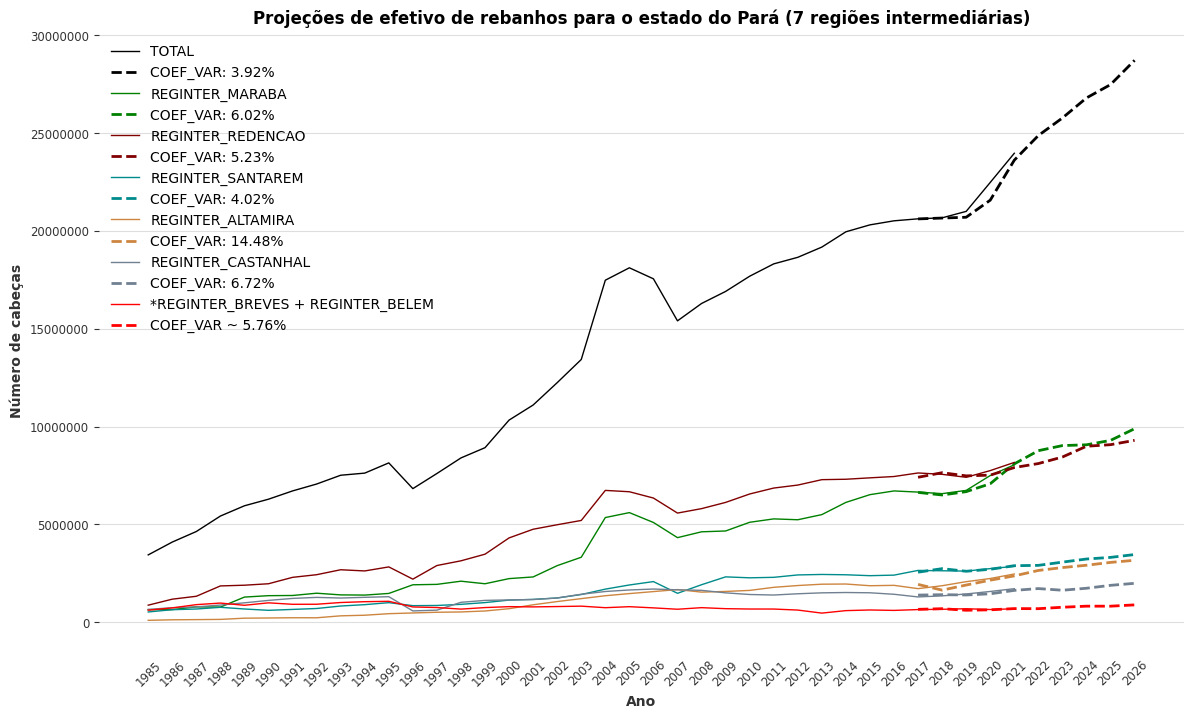

In [8]:
plot_base.show(main_var = 'VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO',
               y_label = 'Número de cabeças', 
               title = 'Projeções de efetivo de rebanhos para o estado do Pará (7 regiões intermediárias)',
               ignored_labels = ['VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_BELEM',
                                'VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_BREVES'])

### Marabá

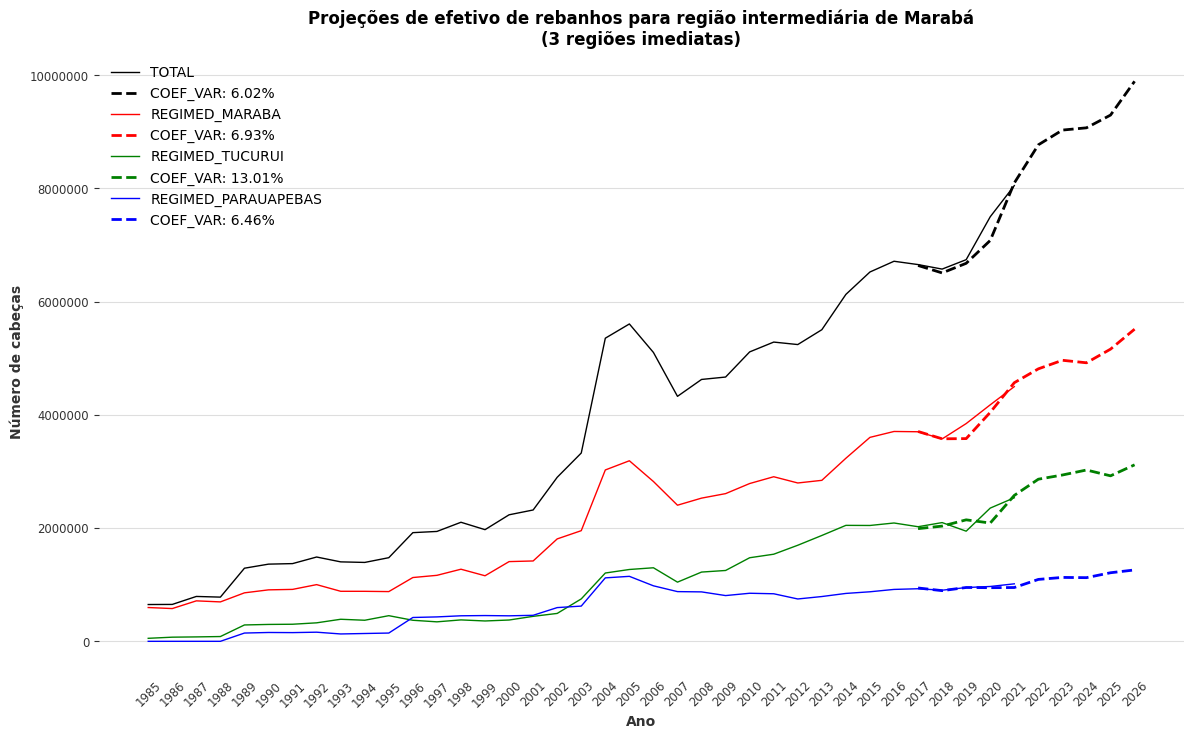

In [9]:
plot_base.show(main_var = 'VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_MARABA',
               y_label = 'Número de cabeças', 
               title = 'Projeções de efetivo de rebanhos para região intermediária de Marabá\n(3 regiões imediatas)')

### Redenção

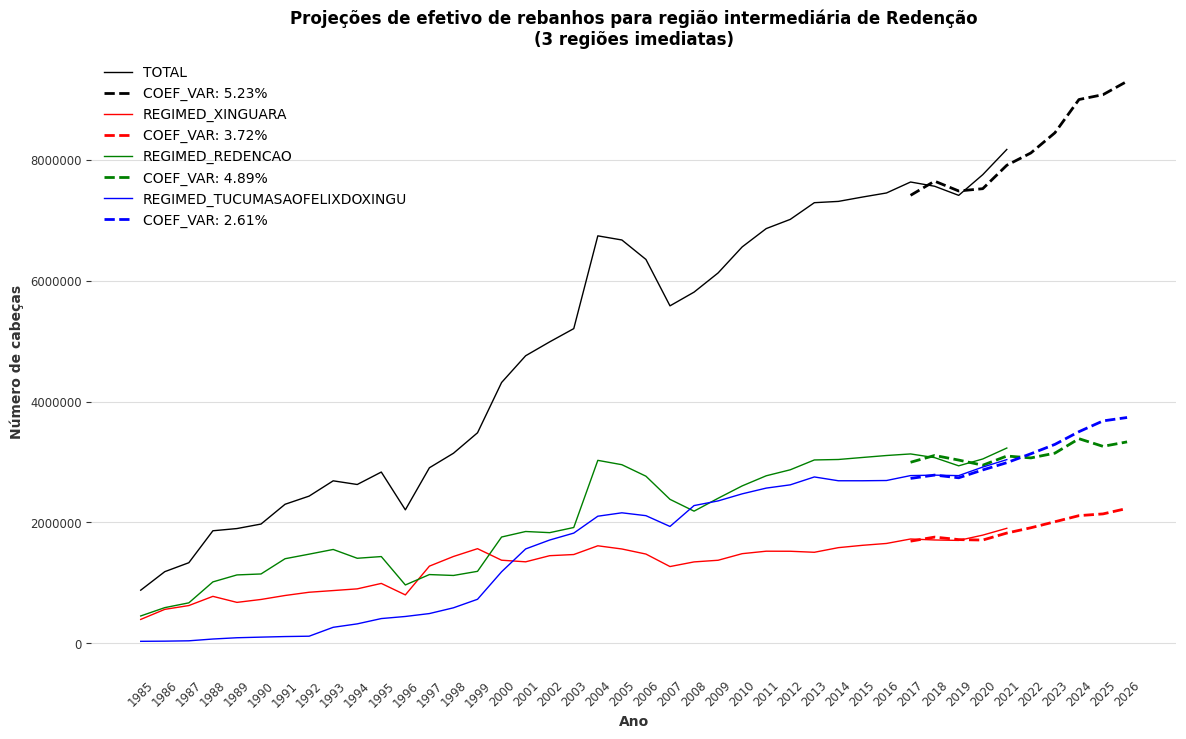

In [10]:
plot_base.show(main_var = 'VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_REDENCAO',
               y_label = 'Número de cabeças', 
               title ='Projeções de efetivo de rebanhos para região intermediária de Redenção\n(3 regiões imediatas)')

## PASTO

### Pará

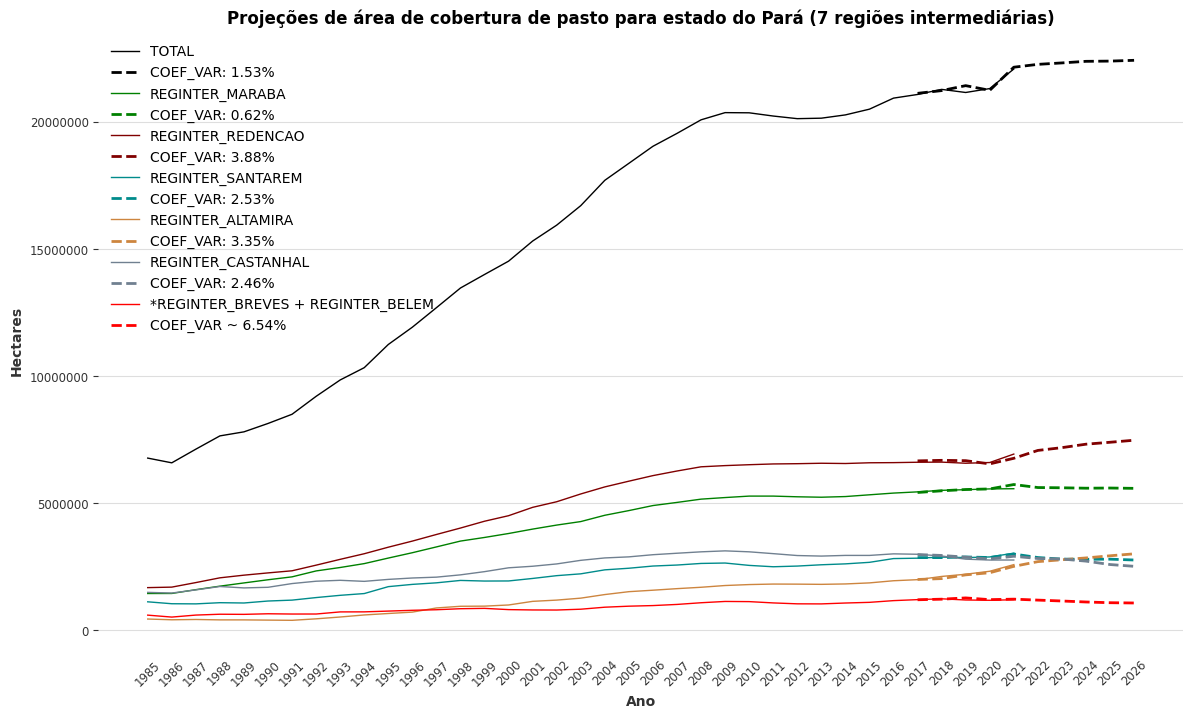

In [11]:
plot_base.show(main_var = 'VAR_AREA_DE_COBERTURA - PRODUTO_PASTO',
               y_label = 'Hectares', 
               title = 'Projeções de área de cobertura de pasto para estado do Pará (7 regiões intermediárias)',
               ignored_labels=['VAR_AREA_DE_COBERTURA - PRODUTO_PASTO - REGINTER_BELEM',
                               'VAR_AREA_DE_COBERTURA - PRODUTO_PASTO - REGINTER_BREVES'])

### Marabá

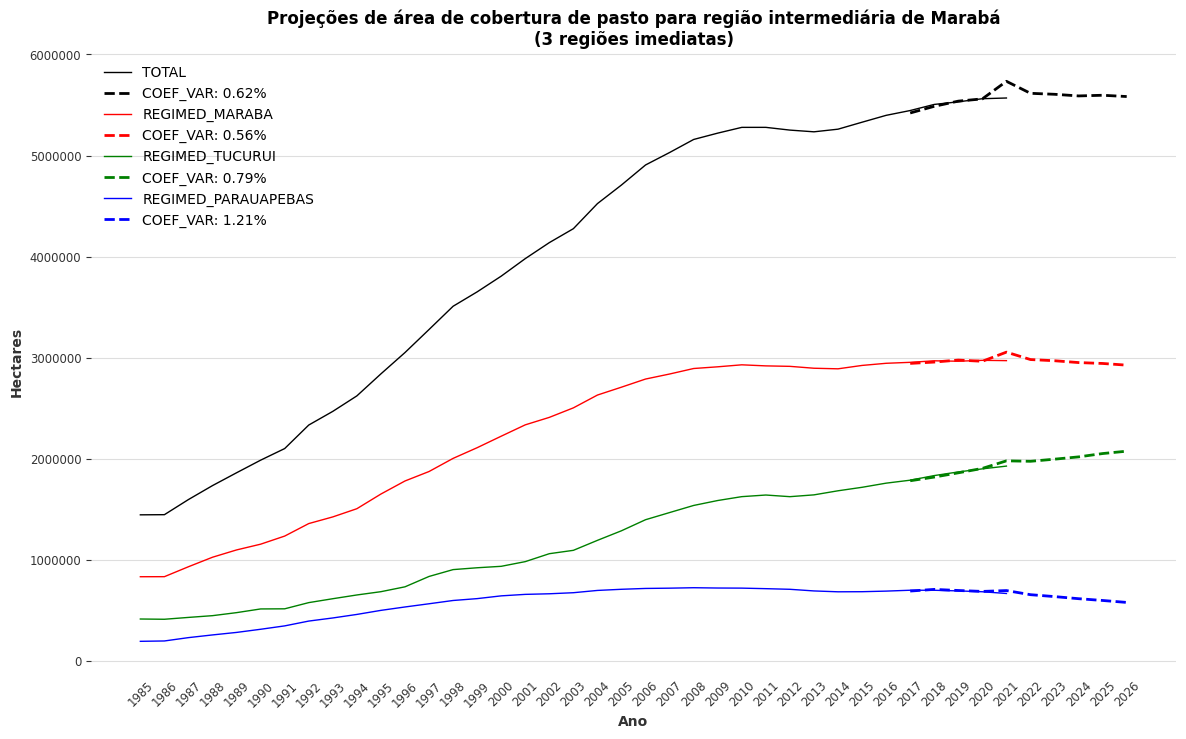

In [12]:
plot_base.show(main_var = 'VAR_AREA_DE_COBERTURA - PRODUTO_PASTO - REGINTER_MARABA',
               y_label = 'Hectares', 
               title = 'Projeções de área de cobertura de pasto para região intermediária de Marabá\n(3 regiões imediatas)')

### Redenção

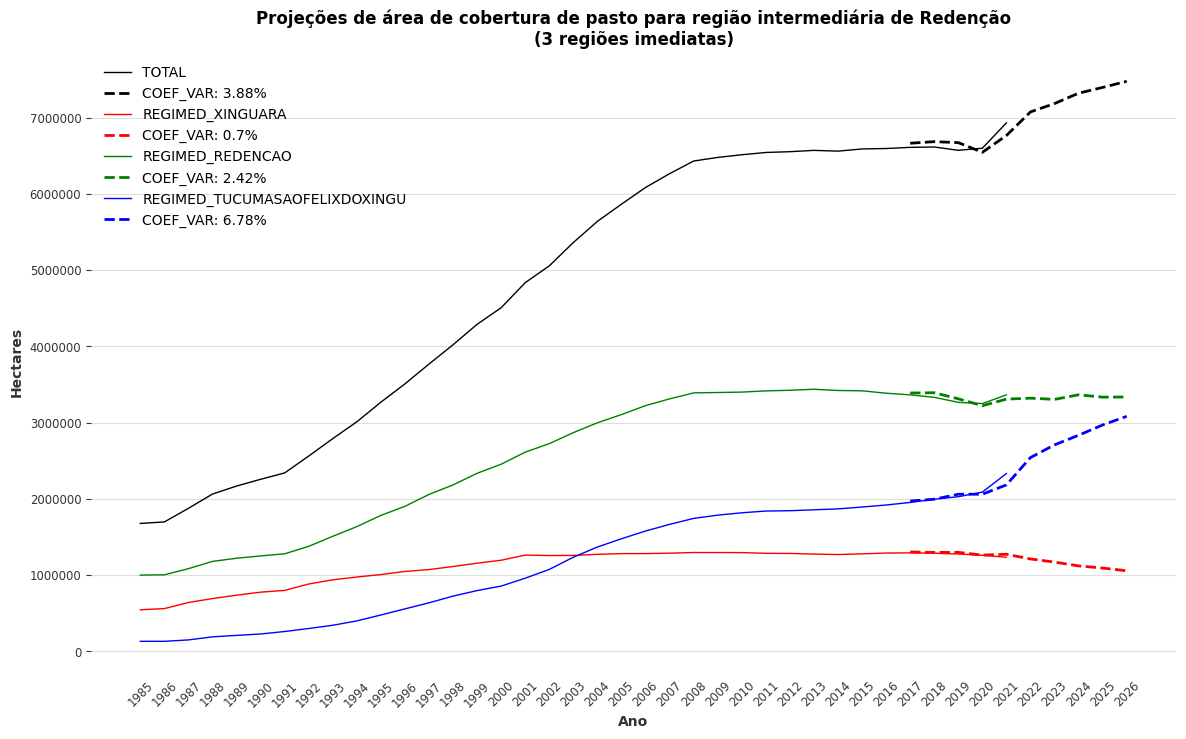

In [13]:
plot_base.show(main_var = 'VAR_AREA_DE_COBERTURA - PRODUTO_PASTO - REGINTER_REDENCAO',
               y_label = 'Hectares', 
               title = 'Projeções de área de cobertura de pasto para região intermediária de Redenção\n(3 regiões imediatas)')

# Produtividade

In [14]:
predict_arima_df = predict_arima.pd_dataframe().reset_index()

<ipython-input-15-281e6c830e31>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_produtividade[column] = df_final[i] / df_final[j]
<ipython-input-15-281e6c830e31>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_produtividade[column] = predict_arima_df[i] / predict_arima_df[j]
<ipython-input-15-281e6c830e31>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

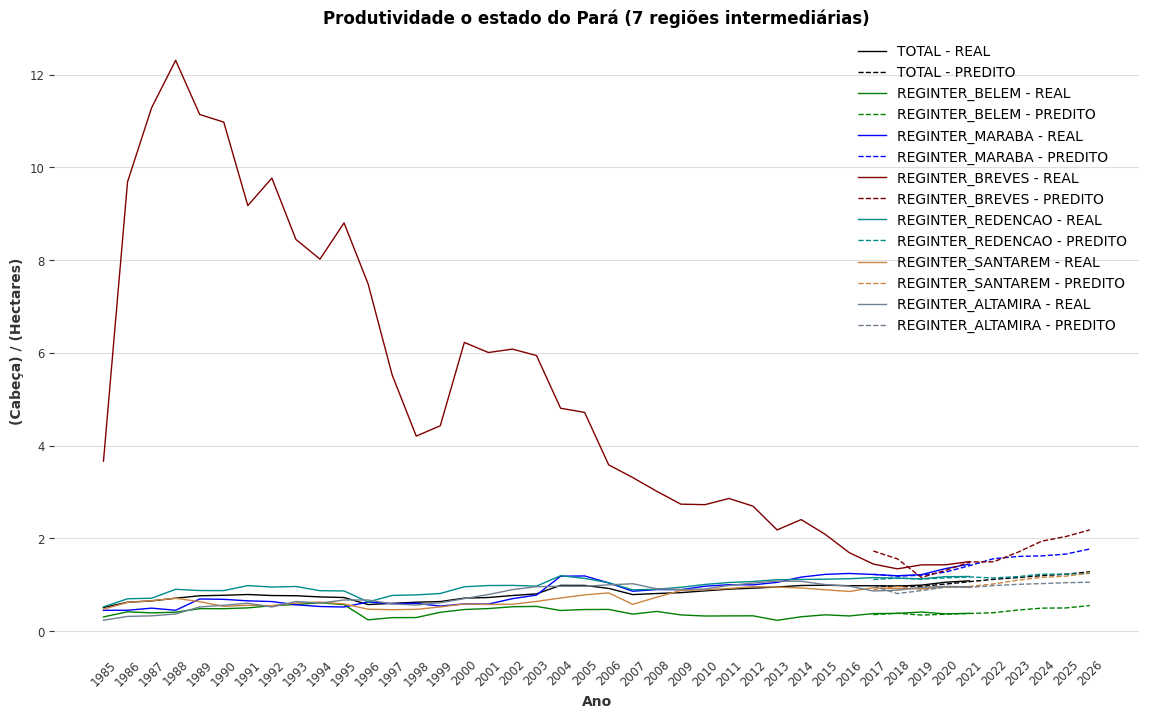

In [15]:
df_produtividade = df_final[['ano']]
df_pred_produtividade = predict_arima_df[['ano']]


for i,j in zip(dict_plot['VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO'], dict_plot['VAR_AREA_DE_COBERTURA - PRODUTO_PASTO']):
    prod_name = i.split(' - ')[-1]
    column =  f'PRODUTIVIDADE - {prod_name}'

    df_produtividade[column] = df_final[i] / df_final[j]
    df_pred_produtividade[column] = predict_arima_df[i] / predict_arima_df[j]

dict_plot['PRODUTIVIDADE'] = df_produtividade.columns

df_produtividade['ano'] = df_final['ano']
df_pred_produtividade['ano'] =  predict_arima_df[['ano']]

df_produtividade['PRODUTIVIDADE'] =  (df_final['VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO'] / df_final['VAR_AREA_DE_COBERTURA - PRODUTO_PASTO'])
df_pred_produtividade['PRODUTIVIDADE'] =  (predict_arima_df['VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO'] / predict_arima_df['VAR_AREA_DE_COBERTURA - PRODUTO_PASTO'])

plot_produtividade = TimeSeries.from_dataframe(df_produtividade, time_col='ano')
predict_arima_ts = TimeSeries.from_dataframe(df_pred_produtividade, time_col='ano')


main_var = 'PRODUTIVIDADE'

title = 'Produtividade o estado do Pará (7 regiões intermediárias)'
y_label = '(Cabeça) / (Hectares)'

plt.figure(figsize=(14, 8))
plt.ticklabel_format(style='plain')
colors = ['r', 'g', 'b', 'maroon', 'darkcyan', 'peru', 'slategray']




plot_produtividade['PRODUTIVIDADE'].plot(lw=1, label = 'TOTAL - REAL', color = 'black')
predict_arima_ts['PRODUTIVIDADE'].plot(lw=1, label = 'TOTAL - PREDITO', color = 'black', linestyle='--')

for i,j in zip(dict_plot[main_var], colors):
    if i != 'ano':
        try:
            i_label = i.split(' - ')[-1]
            plot_produtividade[i].plot(lw=1, label = f'{i_label} - REAL', color = j)
            predict_arima_ts[i].plot(lw=1, label =f'{i_label} - PREDITO', color = j, linestyle='--')
        except KeyError:
            print(f'Variável {i} não encontrada... Ignorando varável')

plt.title(title, fontweight="bold", fontsize=12)
plt.xticks(list(range(1985,2027)), rotation=45)
plt.grid(axis='x')
plt.ylabel(y_label)
plt.xlabel('Ano')
plt.show()

<ipython-input-16-4c38404b0d98>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_produtividade[column] = df_final[i] / df_final[j]
<ipython-input-16-4c38404b0d98>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_produtividade[column] = predict_arima_df[i] / predict_arima_df[j]
<ipython-input-16-4c38404b0d98>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

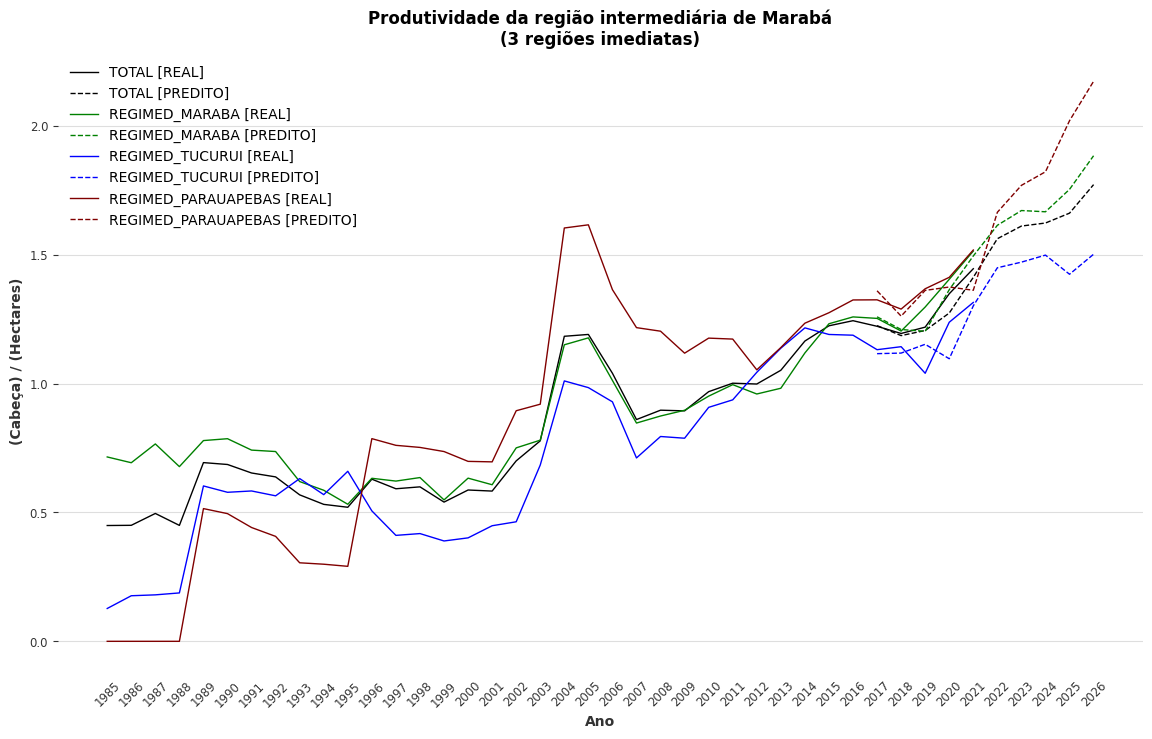

In [16]:
df_produtividade = df_final[['ano']]
df_pred_produtividade = predict_arima_df[['ano']]


for i,j in zip(dict_plot['VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_MARABA'], dict_plot['VAR_AREA_DE_COBERTURA - PRODUTO_PASTO - REGINTER_MARABA']):
    prod_name = i.split(' - ')[-1]
    column =  f'PRODUTIVIDADE - {prod_name}'

    df_produtividade[column] = df_final[i] / df_final[j]
    df_pred_produtividade[column] = predict_arima_df[i] / predict_arima_df[j]

dict_plot['PRODUTIVIDADE - REGINTER_MARABA'] = df_produtividade.columns

df_produtividade['ano'] = df_final['ano']
df_pred_produtividade['ano'] =  predict_arima_df[['ano']]

df_produtividade['PRODUTIVIDADE - REGINTER_MARABA'] =  (df_final['VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_MARABA'] / df_final['VAR_AREA_DE_COBERTURA - PRODUTO_PASTO - REGINTER_MARABA'])
df_pred_produtividade['PRODUTIVIDADE - REGINTER_MARABA'] =  (predict_arima_df['VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_MARABA'] / predict_arima_df['VAR_AREA_DE_COBERTURA - PRODUTO_PASTO - REGINTER_MARABA'])

plot_produtividade = TimeSeries.from_dataframe(df_produtividade, time_col='ano')
predict_arima_ts = TimeSeries.from_dataframe(df_pred_produtividade, time_col='ano')



main_var = 'PRODUTIVIDADE - REGINTER_MARABA'


title = 'Produtividade da região intermediária de Marabá\n(3 regiões imediatas)'
y_label = '(Cabeça) / (Hectares)'

plt.figure(figsize=(14, 8))
plt.ticklabel_format(style='plain')
colors = ['r', 'g', 'b', 'maroon', 'darkcyan', 'peru', 'slategray']



plot_produtividade['PRODUTIVIDADE - REGINTER_MARABA'].plot(lw=1, label = 'TOTAL [REAL]', color = 'black')
predict_arima_ts['PRODUTIVIDADE - REGINTER_MARABA'].plot(lw=1, label = 'TOTAL [PREDITO]', color = 'black', linestyle='--')

for i,j in zip(dict_plot[main_var], colors):
    if i != 'ano':
        try:
            i_label = i.split(' - ')[-1]
            plot_produtividade[i].plot(lw=1, label = f'{i_label} [REAL]', color = j)
            predict_arima_ts[i].plot(lw=1, label =f'{i_label} [PREDITO]', color = j, linestyle='--')
        except KeyError:
            print(f'Variável {i} não encontrada... Ignorando varável')




plt.title(title, fontweight="bold", fontsize=12)
plt.xticks(list(range(1985,2027)), rotation=45)
plt.grid(axis='x')
plt.ylabel(y_label)
plt.xlabel('Ano')
plt.show()

<ipython-input-17-48f733bac344>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_produtividade[column] = df_final[i] / df_final[j]
<ipython-input-17-48f733bac344>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_produtividade[column] = predict_arima_df[i] / predict_arima_df[j]
<ipython-input-17-48f733bac344>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

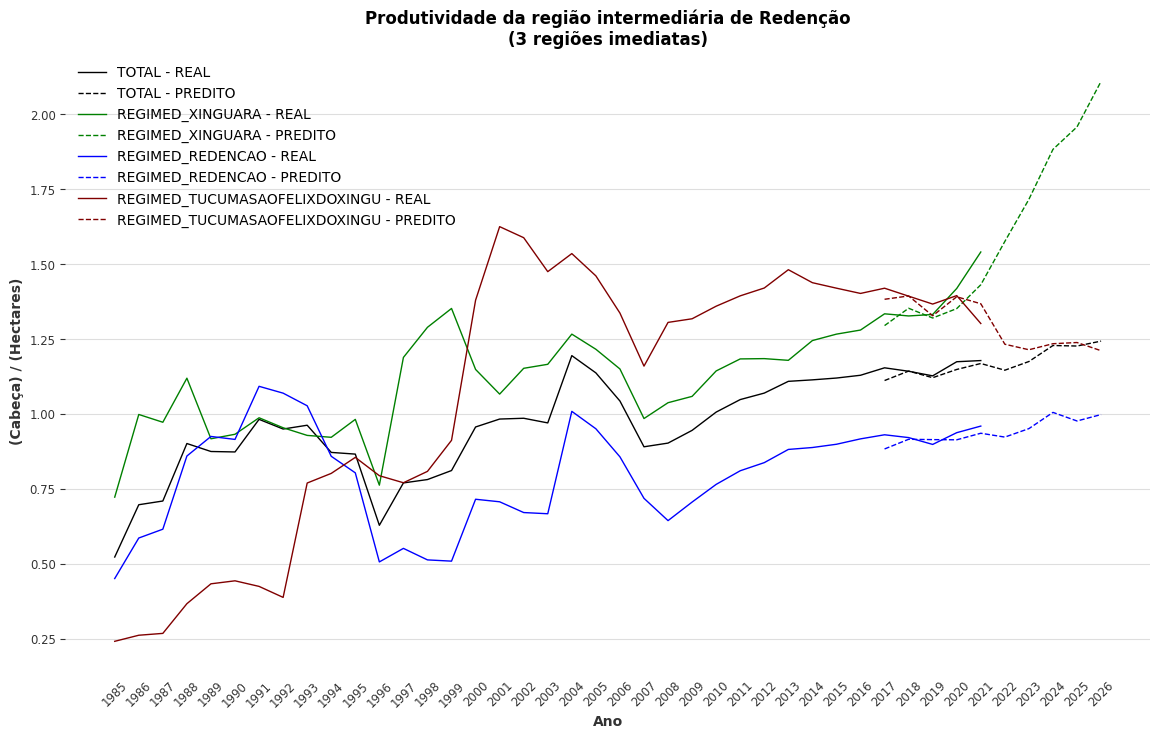

In [17]:
df_produtividade = df_final[['ano']]
df_pred_produtividade = predict_arima_df[['ano']]


for i,j in zip(dict_plot['VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_REDENCAO'], dict_plot['VAR_AREA_DE_COBERTURA - PRODUTO_PASTO - REGINTER_REDENCAO']):
    prod_name = i.split(' - ')[-1]
    column =  f'PRODUTIVIDADE - {prod_name}'

    df_produtividade[column] = df_final[i] / df_final[j]
    df_pred_produtividade[column] = predict_arima_df[i] / predict_arima_df[j]

dict_plot['PRODUTIVIDADE - REGINTER_REDENCAO'] = df_produtividade.columns

df_produtividade['ano'] = df_final['ano']
df_pred_produtividade['ano'] =  predict_arima_df[['ano']]

df_produtividade['PRODUTIVIDADE - REGINTER_REDENCAO'] =  (df_final['VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_REDENCAO'] / df_final['VAR_AREA_DE_COBERTURA - PRODUTO_PASTO - REGINTER_REDENCAO'])
df_pred_produtividade['PRODUTIVIDADE - REGINTER_REDENCAO'] =  (predict_arima_df['VAR_EFETIVO_DOS_REBANHOS - PRODUTO_BOVINO - REGINTER_REDENCAO'] / predict_arima_df['VAR_AREA_DE_COBERTURA - PRODUTO_PASTO - REGINTER_REDENCAO'])

plot_produtividade = TimeSeries.from_dataframe(df_produtividade, time_col='ano')
predict_arima_ts = TimeSeries.from_dataframe(df_pred_produtividade, time_col='ano')



main_var = 'PRODUTIVIDADE - REGINTER_REDENCAO'

title = 'Produtividade da região intermediária de Redenção\n(3 regiões imediatas)'
y_label = '(Cabeça) / (Hectares)'

plt.figure(figsize=(14, 8))
plt.ticklabel_format(style='plain')
colors = ['r', 'g', 'b', 'maroon', 'darkcyan', 'peru', 'slategray']


plot_produtividade['PRODUTIVIDADE - REGINTER_REDENCAO'].plot(lw=1, label = 'TOTAL - REAL', color = 'black')
predict_arima_ts['PRODUTIVIDADE - REGINTER_REDENCAO'].plot(lw=1, label = 'TOTAL - PREDITO', color = 'black', linestyle='--')

for i,j in zip(dict_plot[main_var], colors):
    if i != 'ano':
        try:
            i_label = i.split(' - ')[-1]
            plot_produtividade[i].plot(lw=1, label = f'{i_label} - REAL', color = j)
            predict_arima_ts[i].plot(lw=1, label =f'{i_label} - PREDITO', color = j, linestyle='--')
        except KeyError:
            print(f'Variável {i} não encontrada... Ignorando varável')



plt.title(title, fontweight="bold", fontsize=12)
plt.xticks(list(range(1985,2027)), rotation=45)
plt.grid(axis='x')
plt.ylabel(y_label)
plt.xlabel('Ano')
plt.show()

In [18]:
pd.DataFrame(score_arima, index=[0]).T.mean()

0   6.353480
dtype: float64